<br>

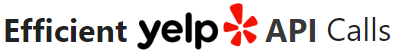

<font size=3><ul><li>Suganthan Thamotharampillai
<br><li>01.31.2023
<div style="border-style:solid;border-color:red;border-width:10px;border-width:0px;border-top-width:7px;">